In [130]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [131]:
# participant_code = 'W1D9N0B8'
participant_code = 'M3A2H7Q4' 

data = pd.read_csv(f'data/{participant_code}.csv', comment='#')
state_data = pd.read_csv(f'data/3d_eye_states_{participant_code}.csv', comment='#')

with open(f'data/{participant_code}.csv', 'r+') as f:
  for line in f.readlines():
    if line.startswith('#Recording time'):
      timestamp_str = line.replace('#Recording time,Date: ', '')
      timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
      break


ts = pd.to_datetime(timestamp_str, format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
ts = ts - timedelta(hours=2)

nanoseconds = int(ts.value)


/tmp/ipykernel_382590/2450088348.py:4: DtypeWarning: Columns (3,4,6,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'data/{participant_code}.csv', comment='#')


In [132]:
interpolated_data = data.interpolate('pad')
trimmed_data = interpolated_data[['Timestamp', 'Channel 13 (Raw)','Channel 9 (Raw)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
       'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]

/tmp/ipykernel_382590/1984626607.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data = data.interpolate('pad')


In [133]:
before_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[0]
before_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='Experiment') & (trimmed_data['MarkerType']=='S')].iloc[-1]

calm_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
calm_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='CalmAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

interim_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
interim_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='InterimAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]

intense_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='S')].iloc[0]
intense_audio_end = trimmed_data[trimmed_data['MarkerName'].notna() & (trimmed_data['MarkerName']=='IntenseAudio') & (trimmed_data['MarkerType']=='E')].iloc[0]




calmFirst = calm_audio_start['Timestamp'] < intense_audio_end['Timestamp']

if calmFirst:
  after_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (
      trimmed_data['MarkerName'] == 'IntenseAudio') &
                                   (trimmed_data['MarkerType'] == 'E')].iloc[0]
  after_audio_end = trimmed_data[trimmed_data['MarkerName'].notna()
                                 & (trimmed_data['MarkerName'] == 'Experiment')
                                 & (trimmed_data['MarkerType'] == 'E')].iloc[0]
else:
  after_audio_start = trimmed_data[trimmed_data['MarkerName'].notna() & (
      trimmed_data['MarkerName'] == 'CalmAudio') &
                                   (trimmed_data['MarkerType'] == 'E')].iloc[0]
  after_audio_end = trimmed_data[trimmed_data['MarkerName'].notna()
                                 & (trimmed_data['MarkerName'] == 'Experiment')
                                 & (trimmed_data['MarkerType'] == 'E')].iloc[0]

In [134]:
before_range = np.arange(before_audio_start['Timestamp'], before_audio_end['Timestamp'])
calm_range = np.arange(calm_audio_start['Timestamp'], calm_audio_end['Timestamp'])
interim_range = np.arange(interim_audio_start['Timestamp'],interim_audio_end['Timestamp'])
intense_range = np.arange(intense_audio_start['Timestamp'], intense_audio_end['Timestamp'])
after_range = np.arange(after_audio_start['Timestamp'], after_audio_end['Timestamp'])
total_range = np.arange(before_audio_start['Timestamp'],after_audio_end['Timestamp']) 
  # before_audio.iloc[0]['Timestamp'],calm_audio.iloc[0]['Timestamp'],interim_audio.iloc[0]['Timestamp'], intense_audio.iloc[0]['Timestamp'],after_audio.iloc[0]['Timestamp'] ]

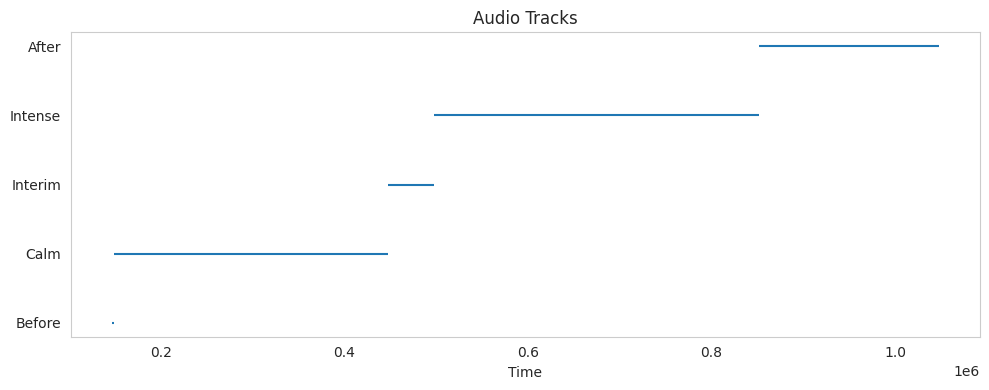

In [135]:


fig, ax = plt.subplots(figsize=(10, 4))

# Example Y positions for each class
class_labels = ['Before', 'Calm', 'Interim', 'Intense', 'After']
class_y = {
    'before': 0,
    'calm': 1,
    'interim': 2,
    'intense': 3,
    'after': 4
}

# Draw horizontal lines for each class range
ax.hlines(y=class_y['before'], xmin=before_range[0], xmax=before_range[-1], label='Before')
ax.hlines(y=class_y['calm'], xmin=calm_range[0], xmax=calm_range[-1], label='Calm')
ax.hlines(y=class_y['interim'], xmin=interim_range[0], xmax=interim_range[-1], label='Interim')
ax.hlines(y=class_y['intense'], xmin=intense_range[0], xmax=intense_range[-1], label='Intense')
ax.hlines(y=class_y['after'], xmin=after_range[0], xmax=after_range[-1], label='After')

ax.set_yticks(list(class_y.values()))
ax.set_yticklabels(class_labels)
ax.set_xlabel('Time')
ax.set_title('Audio Tracks')
ax.grid(False)
plt.tight_layout()
plt.show()


In [136]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

def plot_column(trimmed_data, column='VelocityX', unit='m'):

    # Set the figure size and style
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    # Plot the fixation duration over time
    plt.plot(trimmed_data['Timestamp'], trimmed_data[column],
            color='#3498db', linewidth=1.5, alpha=0.7)

    # Define color scheme for different audio segments
    colors = {
        'Before': '#D3D3D3',  # Light gray
        'Calm': '#90CAF9',    # Light blue
        'Interim': '#FFD54F', # Light amber
        'Intense': '#EF5350', # Light red
        'After': '#D3D3D3'    # Light gray
    }

    # Add colored background regions for each audio segment
    y_min, y_max = plt.ylim()
    plt.axvspan(before_audio_start['Timestamp'], before_audio_end['Timestamp'],
                alpha=0.2, color=colors['Before'], label='Before Audio')
    plt.axvspan(calm_audio_start['Timestamp'], calm_audio_end['Timestamp'],
                alpha=0.2, color=colors['Calm'], label='Calm Audio')
    plt.axvspan(interim_audio_start['Timestamp'], interim_audio_end['Timestamp'],
                alpha=0.2, color=colors['Interim'], label='Interim Audio')
    plt.axvspan(intense_audio_start['Timestamp'], intense_audio_end['Timestamp'],
                alpha=0.2, color=colors['Intense'], label='Intense Audio')
    plt.axvspan(intense_audio_end['Timestamp'], after_audio_end['Timestamp'],
                alpha=0.2, color=colors['After'], label='After Audio')

    # Add vertical lines at transition points
    plt.axvline(x=before_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=calm_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=calm_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=calm_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=interim_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=interim_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=intense_audio_start['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=intense_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=after_audio_end['Timestamp'], color='black', linestyle='--', alpha=0.7)

    # Add titles and labels
    plt.title(f'{column} During Different Audio Segments', fontsize=16, pad=20)
    plt.xlabel('Time (ms)', fontsize=12)
    plt.ylabel(f'{column} ({unit})', fontsize=12)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

    # Improve x-axis readability by converting to relative time
    relative_timestamps = []

    plt.xticks([t[1] for t in relative_timestamps],
            [f"{t[0]}\n{t[2]:.1f}s" for t in relative_timestamps],
            rotation=45)

    plt.tight_layout()

/tmp/ipykernel_382590/240212867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).std()


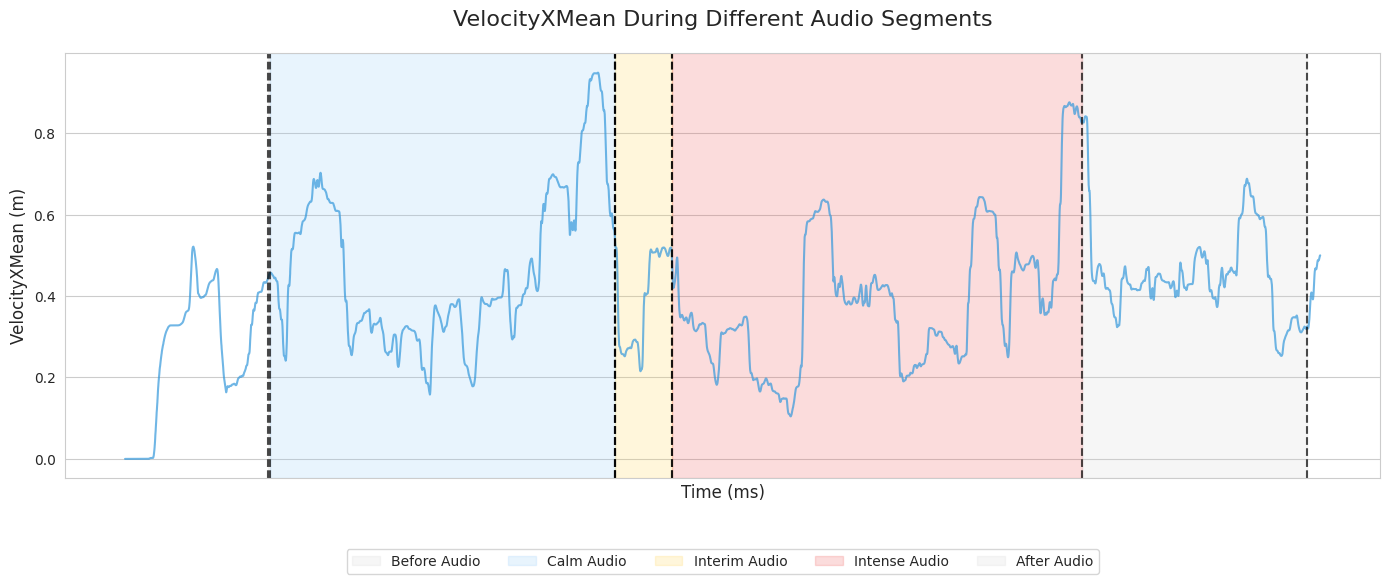

In [137]:
trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).std()

plot_column(trimmed_data, 'VelocityXMean')


In [138]:
trimmed_data.columns

Index(['Timestamp', 'Channel 13 (Raw)', 'Channel 9 (Raw)', 'MarkerName',
       'MarkerDescription', 'MarkerType', 'DistanceToNextSpeedSign',
       'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
       'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight',
       'VelocityXMean'],
      dtype='object')

/tmp/ipykernel_382590/4262087357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()


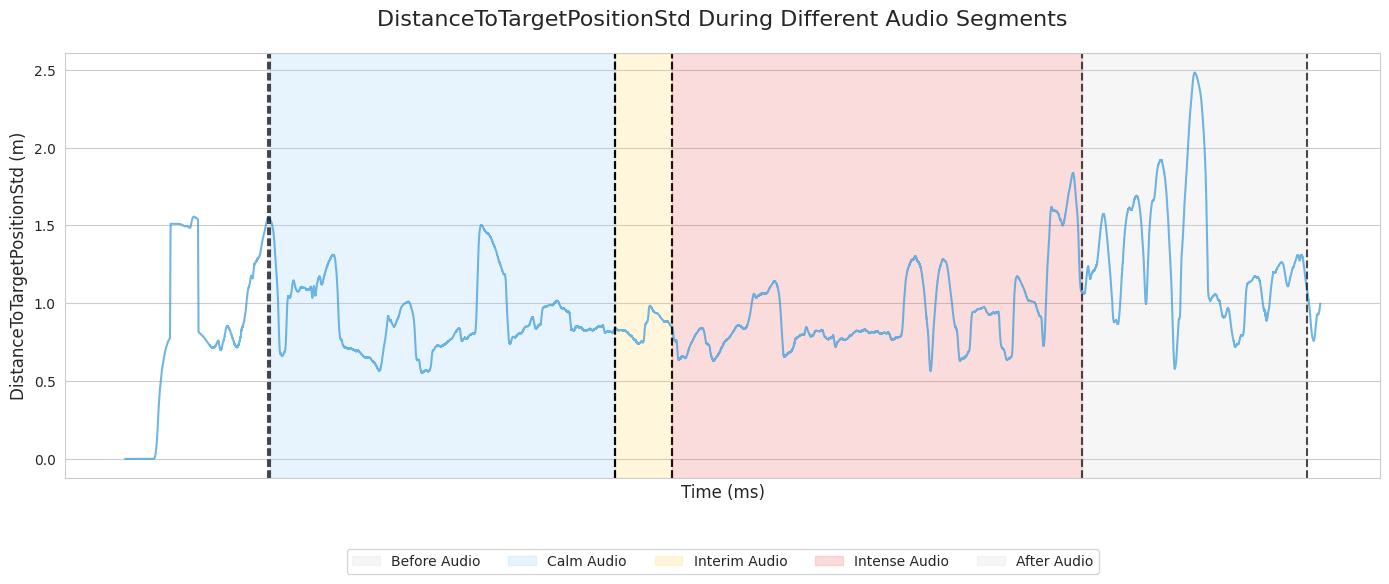

In [139]:
trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()

plot_column(trimmed_data, 'DistanceToTargetPositionStd')

In [140]:
state_data['timestamp [ns]'] = state_data['timestamp [ns]'].apply(lambda x: (x - nanoseconds)/ (10**6))

state_data.rename(columns={'timestamp [ns]': 'Timestamp'}, inplace=True)
state_data.rename(columns={'pupil diameter left [mm]': 'ET_PupilLeft'}, inplace=True)
state_data.rename(columns={'pupil diameter right [mm]': 'ET_PupilRight'},
                  inplace=True)

data['ET_PupilLeft'] = np.nan
data['ET_PupilRight'] = np.nan

subset = state_data[['Timestamp', 'ET_PupilLeft','ET_PupilRight']]

# Append to df1
combined = pd.concat([data, subset], ignore_index=True)

# Sort by timestep
combined_sorted = combined.sort_values(by='Timestamp').reset_index(drop=True)

interpolated_data2 = combined_sorted.interpolate('pad')
trimmed_data2 = interpolated_data2[['Timestamp', 'Channel 13 (Raw)','Channel 9 (Raw)', 'MarkerName','MarkerDescription','MarkerType', 'DistanceToNextSpeedSign', 'DistanceToNextOverheadSign', 'VelocityX', 'DistanceToTargetPosition',
       'DistanceToTargetSpeed', 'CarSpeed', 'ET_PupilLeft', 'ET_PupilRight']]

/tmp/ipykernel_382590/527130851.py:19: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_data2 = combined_sorted.interpolate('pad')


/tmp/ipykernel_382590/2125213662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data2['ET_PupilRight_Mean'] = trimmed_data2['ET_PupilRight'].rolling(window=10000).mean()


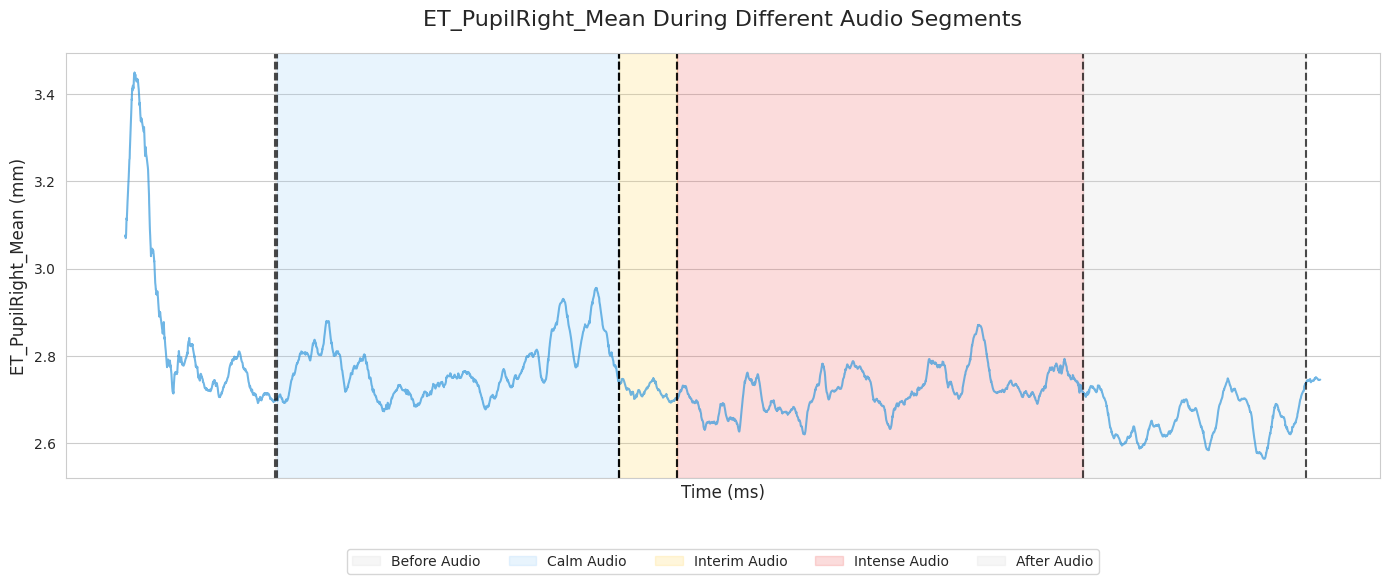

In [141]:
trimmed_data2['ET_PupilRight_Mean'] = trimmed_data2['ET_PupilRight'].rolling(window=10000).mean()
plot_column(trimmed_data2, 'ET_PupilRight_Mean', 'mm')

In [142]:
from scipy.stats import ttest_rel, mannwhitneyu, levene, ks_2samp




def statistical_tests(column='DistanceToTargetPosition',
                      xlabel='Distance to Correct Lane',
                      ax=None):

  if ax is None:
    fig, ax = plt.subplots()

  calm_range = np.arange(calm_audio_start['Timestamp'],
                         calm_audio_end['Timestamp'])
  intense_range = np.arange(intense_audio_start['Timestamp'],
                            intense_audio_end['Timestamp'])

  start1, end1 = calm_range[0], calm_range[-1]
  start2, end2 = intense_range[0], intense_range[-1]
  segment1 = trimmed_data[(trimmed_data['Timestamp'] > start1) &
                          (trimmed_data['Timestamp'] < end1)][column].dropna()
  segment2 = trimmed_data[(trimmed_data['Timestamp'] > start2) &
                          (trimmed_data['Timestamp'] < end2)][column].dropna()

  if len(segment1) < len(segment2):
    cut_length = len(segment1)
  else:
    cut_length = len(segment1)
  print(f'dropped {abs(len(segment1) - len(segment2))} samples of {max(len(segment1) , len(segment2))}')
  t_stat, t_p = ttest_rel(segment1.iloc[:cut_length], segment2.iloc[:cut_length])
  print("paired t-test:", f"t={t_stat:.3f}, p={t_p:.3g}")

  # u_stat, u_p = mannwhitneyu(segment1, segment2, alternative='two-sided')
  # print("Mann–Whitney U:", f"U={u_stat}, p={u_p:.3g}")

  # lev_stat, lev_p = levene(segment1, segment2)
  # print("Levene’s test:", f"stat={lev_stat:.3f}, p={lev_p:.3g}")

  # ks_stat, ks_p = ks_2samp(segment1, segment2)

  # print("KS test:", f"stat={ks_stat:.3f}, p={ks_p:.3g}")

  def cohen_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 +
                          (ny - 1) * np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

  # d = cohen_d(segment1, segment2)
  # print("Cohen's d:", d)
  #   plt.figure(figsize=(10, 5))
  sns.kdeplot(segment1, label='Calm Audio', ax=ax)
  sns.kdeplot(segment2, label='Intense Audio', ax=ax)
  ax.set_title('Distribution Comparison')
  ax.set_xlabel(xlabel)
  ax.legend()
  return ax


dropped 20680 samples of 141932
paired t-test: t=-0.430, p=0.667
dropped 20680 samples of 141932
paired t-test: t=-10.663, p=1.55e-26
dropped 20680 samples of 141932
paired t-test: t=27.991, p=7.47e-172


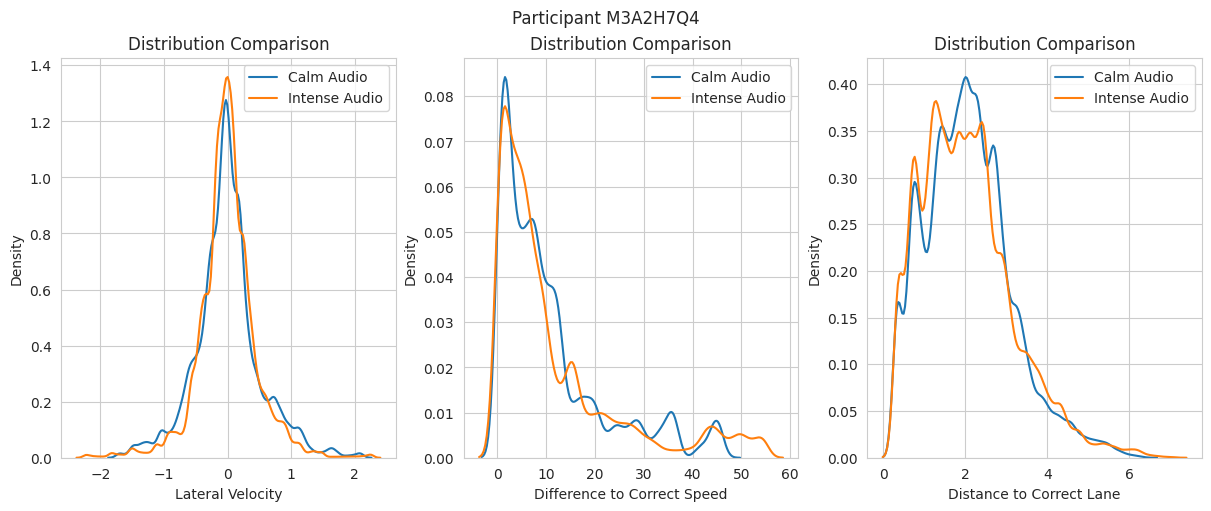

In [143]:
pairs = [
    ('VelocityX', 'Lateral Velocity'),
    ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
    ('DistanceToTargetPosition','Distance to Correct Lane')
]

# Create a figure with enough subplots (3 rows, 1 column here)
fig, axes = plt.subplots(1, len(pairs), figsize=(4*len(pairs), 5), constrained_layout=True)

# If only one subplot, axes is not a list, so make it a list for uniformity:
if len(pairs) == 1:
  axes = [axes]

for ax, (col1, col2) in zip(axes, pairs):
  statistical_tests(col1, col2, ax=ax)

plt.suptitle(f'Participant {participant_code}')
plt.savefig(f'Participant {participant_code}.png',dpi=300)
plt.show()


dropped 20680 samples of 141932
paired t-test: t=-0.430, p=0.667


<Axes: title={'center': 'Distribution Comparison'}, xlabel='Lateral Velocity', ylabel='Density'>

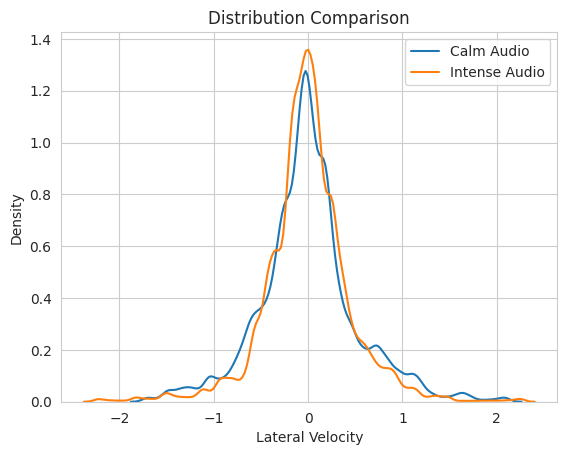

In [144]:
statistical_tests('VelocityX', 'Lateral Velocity')

dropped 20680 samples of 141932
paired t-test: t=-10.663, p=1.55e-26


<Axes: title={'center': 'Distribution Comparison'}, xlabel='Difference to Correct Speed', ylabel='Density'>

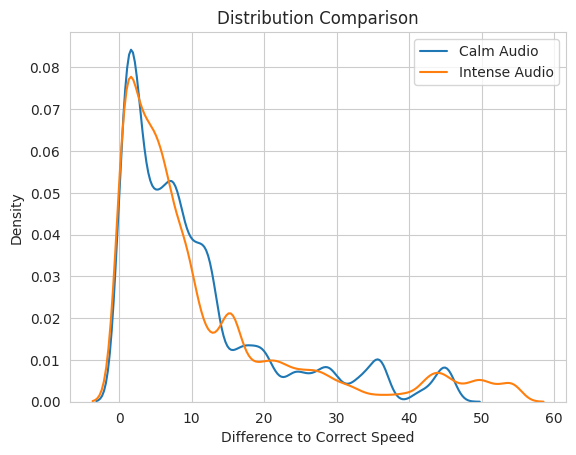

In [145]:
statistical_tests('DistanceToTargetSpeed', 'Difference to Correct Speed')